<a href="https://colab.research.google.com/github/mahhhdy/thesis/blob/main/TEST_LSTM_multiVarient.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [40]:
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense, Dropout
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

!pip install yfinance
import yfinance as yf 

from google.colab import drive
from sklearn.preprocessing import StandardScaler

# drive.mount('/content/drive')
# path='/content/drive/MyDrive/DataSets/BTCPrediction/BitcoinData.csv'

# df = pd.read_csv(path)

In [41]:
df = yf.download(tickers='GAIL.NS',period='5y' ,interval='1d' )

# df = df[::-1].reset_index(drop=True)
df.reset_index(inplace=True)

# idx = pd.Series(range(0,df.shape[0]))
# df = pd.DataFrame(index = idx, data  = df)

df.info()

[*********************100%***********************]  1 of 1 completed
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1236 entries, 0 to 1235
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       1236 non-null   datetime64[ns]
 1   Open       1236 non-null   float64       
 2   High       1236 non-null   float64       
 3   Low        1236 non-null   float64       
 4   Close      1236 non-null   float64       
 5   Adj Close  1236 non-null   float64       
 6   Volume     1236 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 67.7 KB


In [24]:
# # def ConvertDataFrameColumn():
# if(df['Change %'].str.contains('%').any()):
#   df['Change %'] = df['Change %'].str.slice(0, -1)

# if(df['Vol.'].str.contains('K').any() or df['Vol.'].str.contains('M').any()):
#   df['Vol.'] = df['Vol.'].str.slice(0, -1)
    
# for x in ['Price','Open','High','Low']:
#   if(df.dtypes[x]==np.object):
#     df[x] = df[x].str.replace(',','')
#   df[x] = df[x].astype(np.float64)

# df['Vol.'] = pd.to_numeric(df['Vol.'], downcast="float")
# df['Change %'] = pd.to_numeric(df['Change %'], downcast="float")

In [25]:
# ConvertDataFrameColumn()

In [26]:
#Separate dates for future plotting
train_dates = pd.to_datetime(df['Date'])
print(train_dates.tail()) #Check last few dates. 

1231   2022-04-19
1232   2022-04-20
1233   2022-04-21
1234   2022-04-22
1235   2022-04-25
Name: Date, dtype: datetime64[ns]


In [27]:
#Variables for training
cols = list(df)[1:len(df.columns)]
#Date and volume columns are not used in training. 
print(cols) 

['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']


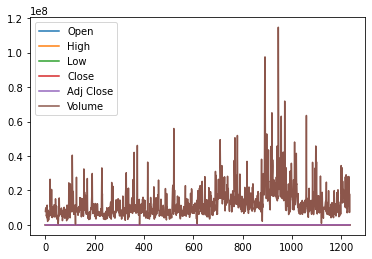

In [28]:
#New dataframe with only training data - 5 columns
df_for_training = df[cols].astype(float)

df_for_plot=df_for_training.tail(5000)
df_for_plot.plot.line()

In [29]:
#LSTM uses sigmoid and tanh that are sensitive to magnitude so values need to be normalized
# normalize the dataset
scaler = StandardScaler()
scaler = scaler.fit(df_for_training)
df_for_training_scaled = scaler.transform(df_for_training)

In [30]:

#As required for LSTM networks, we require to reshape an input data into n_samples x timesteps x n_features. 
#In this example, the n_features is 5. We will make timesteps = 14 (past days data used for training). 

#Empty lists to be populated using formatted training data
trainX = []
trainY = []

n_future = 1   # Number of days we want to look into the future based on the past days.
n_past = 14  # Number of past days we want to use to predict the future.

#Reformat input data into a shape: (n_samples x timesteps x n_features)
#In my example, my df_for_training_scaled has a shape (12823, 5)
#12823 refers to the number of data points and 5 refers to the columns (multi-variables).
for i in range(n_past, len(df_for_training_scaled) - n_future +1):
    trainX.append(df_for_training_scaled[i - n_past:i, 0:df_for_training.shape[1]])
    trainY.append(df_for_training_scaled[i + n_future - 1:i + n_future, 0])

trainX, trainY = np.array(trainX), np.array(trainY)

print('trainX shape == {}.'.format(trainX.shape))
print('trainY shape == {}.'.format(trainY.shape))

trainX shape == (1222, 14, 6).
trainY shape == (1222, 1).


In [31]:

#In my case, trainX has a shape (12809, 14, 5). 
#12809 because we are looking back 14 days (12823 - 14 = 12809). 
#Remember that we cannot look back 14 days until we get to the 15th day. 
#Also, trainY has a shape (12809, 1). Our model only predicts a single value, but 
#it needs multiple variables (5 in my example) to make this prediction. 
#This is why we can only predict a single day after our training, the day after where our data ends.
#To predict more days in future, we need all the 5 variables which we do not have. 
#We need to predict all variables if we want to do that. 

# define the Autoencoder model

model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model.add(LSTM(32, activation='relu', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(trainY.shape[1]))

model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 14, 64)            18176     
                                                                 
 lstm_1 (LSTM)               (None, 32)                12416     
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 30,625
Trainable params: 30,625
Non-trainable params: 0
_________________________________________________________________


Epoch 1/50
69/69 [==============================] - 5s 30ms/step - loss: 0.1476 - val_loss: 0.0480
Epoch 2/50
69/69 [==============================] - 2s 29ms/step - loss: 0.0694 - val_loss: 0.0385
Epoch 3/50
69/69 [==============================] - 2s 33ms/step - loss: 0.0588 - val_loss: 0.0337
Epoch 4/50
69/69 [==============================] - 2s 32ms/step - loss: 0.0543 - val_loss: 0.0253
Epoch 5/50
69/69 [==============================] - 2s 33ms/step - loss: 0.0461 - val_loss: 0.0234
Epoch 6/50
69/69 [==============================] - 2s 32ms/step - loss: 0.0468 - val_loss: 0.0181
Epoch 7/50
69/69 [==============================] - 2s 31ms/step - loss: 0.0416 - val_loss: 0.0169
Epoch 8/50
69/69 [==============================] - 2s 28ms/step - loss: 0.0441 - val_loss: 0.0153
Epoch 9/50
69/69 [==============================] - 2s 31ms/step - loss: 0.0323 - val_loss: 0.0134
Epoch 10/50
69/69 [==============================] - 2s 34ms/step - loss: 0.0327 - val_loss: 0.0123
Epoch 11/

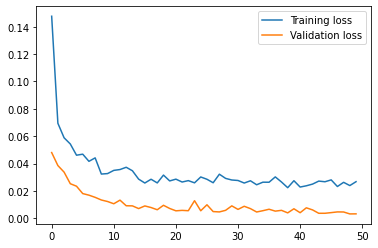

In [32]:
num_epochs = 50
num_batches = 16

# fit the model
history = model.fit(trainX, trainY, epochs=num_epochs, batch_size=num_batches , validation_split=0.1, verbose=1)

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()


In [33]:

#Predicting...
#Libraries that will help us extract only business days in the US.
#Otherwise our dates would be wrong when we look back (or forward).  
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay
us_bd = CustomBusinessDay(calendar=USFederalHolidayCalendar())
#Remember that we can only predict one day in future as our model needs 5 variables
#as inputs for prediction. We only have all 5 variables until the last day in our dataset.


# n_past = 16
# n_days_for_prediction=15  #let us predict past 15 days

n_future = 90


predict_period_dates = pd.date_range(list(train_dates)[-n_past], periods=n_future, freq=us_bd).tolist()
print(predict_period_dates)

#Make prediction
prediction = model.predict(trainX[-n_future:]) #shape = (n, 1) where n is the n_days_for_prediction

#Perform inverse transformation to rescale back to original range
#Since we used 5 variables for transform, the inverse expects same dimensions
#Therefore, let us copy our values 5 times and discard them after inverse transform
prediction_copies = np.repeat(prediction, df_for_training.shape[1], axis=-1)
y_pred_future = scaler.inverse_transform(prediction_copies)[:,0]


[Timestamp('2022-04-04 00:00:00', freq='C'), Timestamp('2022-04-05 00:00:00', freq='C'), Timestamp('2022-04-06 00:00:00', freq='C'), Timestamp('2022-04-07 00:00:00', freq='C'), Timestamp('2022-04-08 00:00:00', freq='C'), Timestamp('2022-04-11 00:00:00', freq='C'), Timestamp('2022-04-12 00:00:00', freq='C'), Timestamp('2022-04-13 00:00:00', freq='C'), Timestamp('2022-04-14 00:00:00', freq='C'), Timestamp('2022-04-15 00:00:00', freq='C'), Timestamp('2022-04-18 00:00:00', freq='C'), Timestamp('2022-04-19 00:00:00', freq='C'), Timestamp('2022-04-20 00:00:00', freq='C'), Timestamp('2022-04-21 00:00:00', freq='C'), Timestamp('2022-04-22 00:00:00', freq='C'), Timestamp('2022-04-25 00:00:00', freq='C'), Timestamp('2022-04-26 00:00:00', freq='C'), Timestamp('2022-04-27 00:00:00', freq='C'), Timestamp('2022-04-28 00:00:00', freq='C'), Timestamp('2022-04-29 00:00:00', freq='C'), Timestamp('2022-05-02 00:00:00', freq='C'), Timestamp('2022-05-03 00:00:00', freq='C'), Timestamp('2022-05-04 00:00:00'

In [34]:
#  Convert timestamp to date
forecast_dates = []
for time_i in predict_period_dates:
    forecast_dates.append(time_i.date())

In [35]:
y_pred_future.shape

(90,)

In [36]:
np.array(forecast_dates).shape

(90,)

In [37]:
df_forecast = pd.DataFrame({'Date':np.array(forecast_dates), 'Open':y_pred_future})
df_forecast['Date']=pd.to_datetime(df_forecast['Date'])

In [38]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2017-04-25,155.943787,155.962540,153.787537,154.312531,125.239449,7836211
1,2017-04-26,155.193787,157.556290,153.525040,154.968781,125.772064,9465781
2,2017-04-27,155.625031,158.212540,154.312531,156.900040,127.339439,8671901
3,2017-04-28,157.068787,159.187546,155.625031,158.981293,129.028595,10076829
4,2017-05-02,159.000046,161.737534,157.218796,161.062546,130.717728,5071785


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


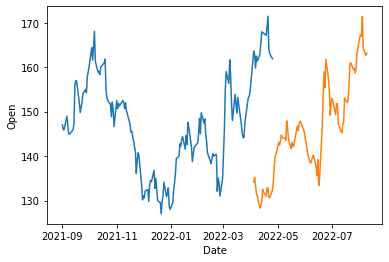

In [49]:
original = df[['Date', 'Open']]
original['Date']=pd.to_datetime(original['Date'])
original = original.loc[original['Date'] >= '2021-9-1']

sns.lineplot(original['Date'], original['Open'])
sns.lineplot(df_forecast['Date'], df_forecast['Open'])